In [61]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [62]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [63]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [64]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### Задание 1:
1. Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;
2. Сделать базовый анализ целевой переменной, сделать выводы;
3. Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;
4. Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;
5. Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?
6. Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.
7. Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

### Базовая статистика и базовый анализ целевой переменной

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [66]:
train.shape

(200000, 202)

In [67]:
TARGET_NAME = 'target'
BASE_FEATURE_NAMES = train.columns.drop(['target','ID_code']).tolist()
BASE_FEATURE_NAMES_FOR_SLOW_MACHINE =  ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 
                                        'var_13', 'var_20', 'var_26', 'var_40', 'var_55', 'var_80',
                                        'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']

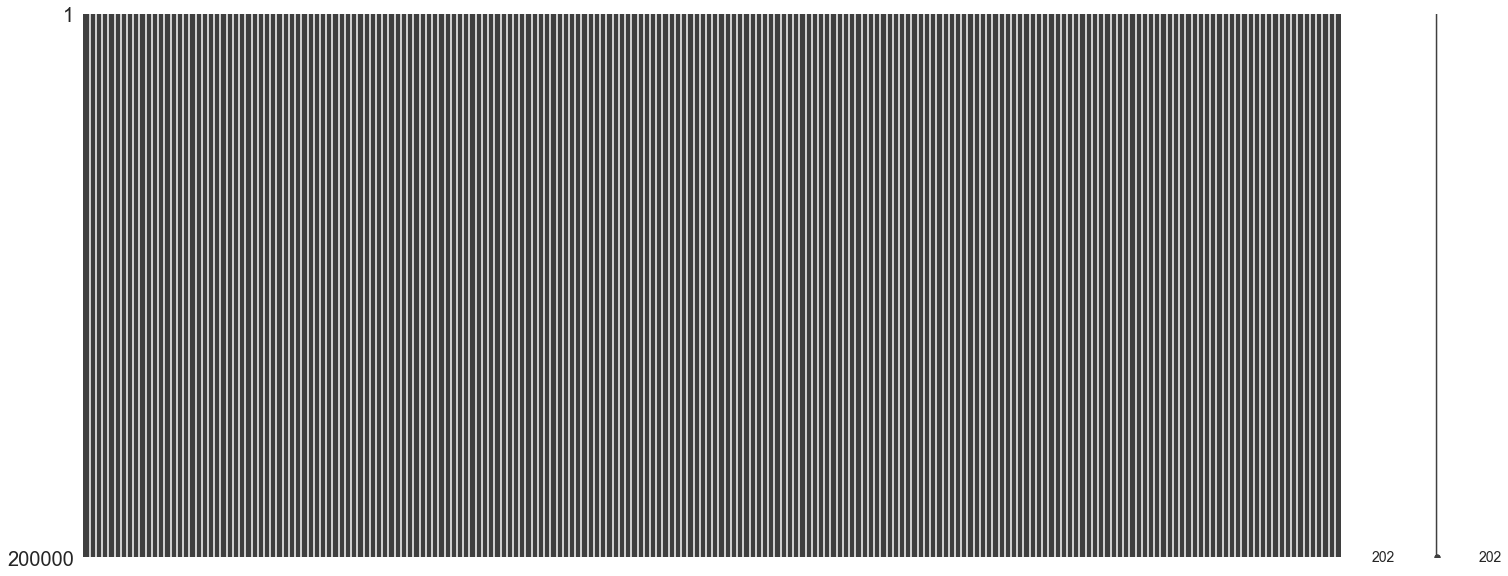

In [68]:
msno.matrix(train)

In [69]:
len(train) - train.count()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

__Выводы:__

Датасет состоит из 200 features по 200000 значений. Целевая переменная булевая (0, 1). Пропуски отсутствуют, все features float64 

###  Распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки

In [30]:
correlation = numerical_features.corr()
corr_with_target = correlation[TARGET_NAME].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

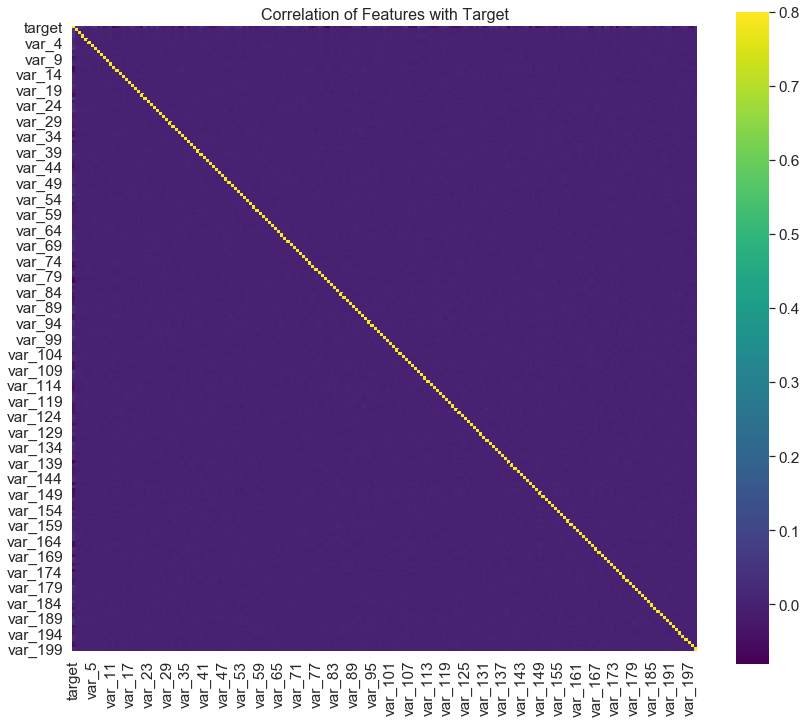

In [31]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Features with Target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

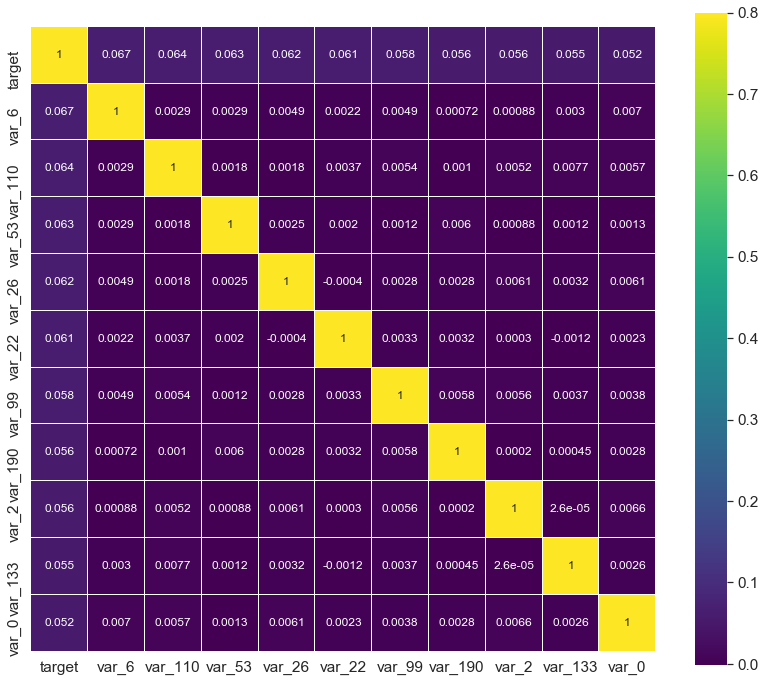

In [33]:
k = 11
cols = correlation.nlargest(k, TARGET_NAME)[TARGET_NAME].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

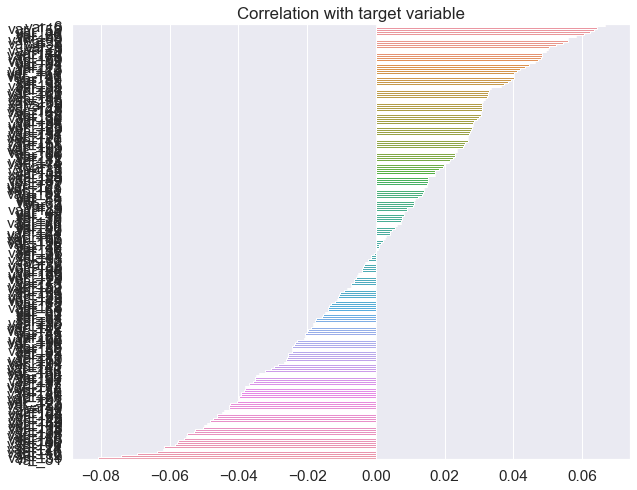

In [34]:
corr_with_target = train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

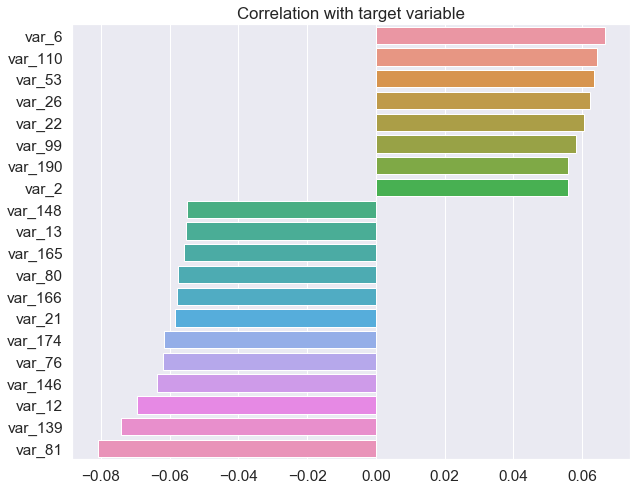

In [55]:
corr_with_target_filt = corr_with_target.where(lambda x: abs(x) > 0.055).dropna()
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target_filt.values, y=corr_with_target_filt.index)
plt.title('Correlation with target variable')
plt.show()

In [56]:
CORR_FEATURES = corr_with_target_filt.index.values

Text(0, 0.5, 'Density')

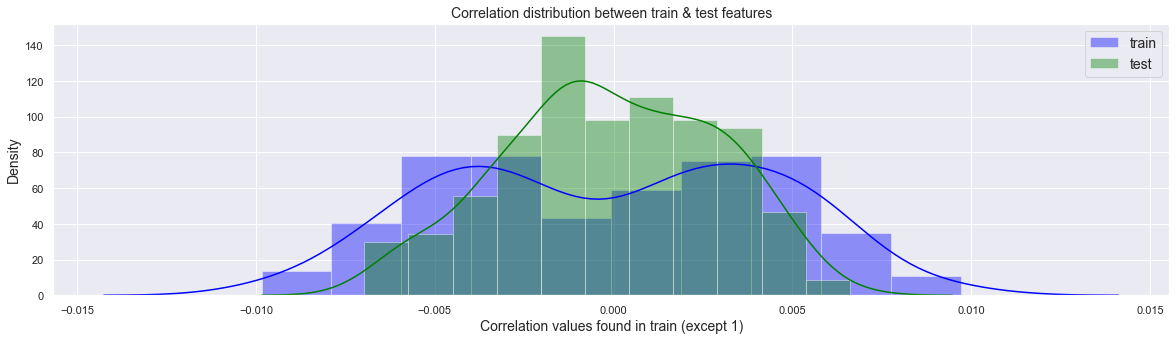

In [70]:
train_correlations = train[CORR_FEATURES].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test[CORR_FEATURES].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Correlation distribution between train & test features", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Text(0, 0.5, 'Density')

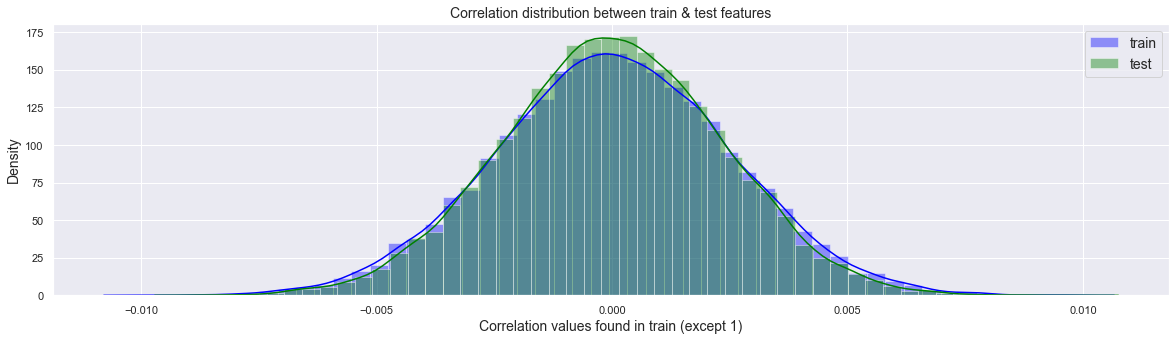

In [71]:
train_correlations = train[BASE_FEATURE_NAMES].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test[BASE_FEATURE_NAMES].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Correlation distribution between train & test features", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

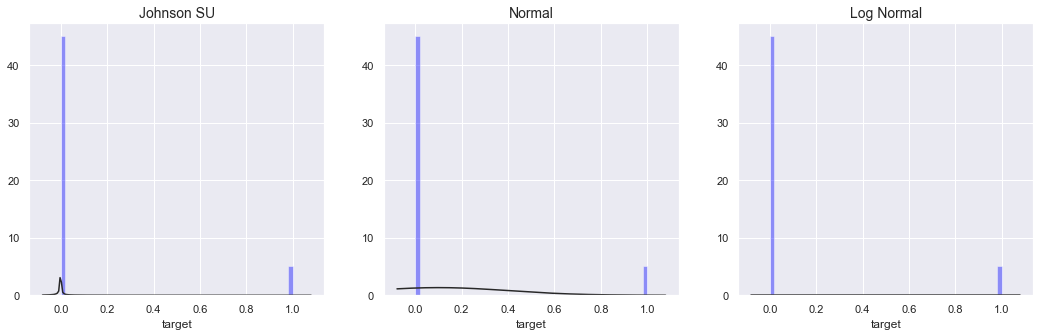

In [72]:
target = train[TARGET_NAME]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])

### Анализ нелинейной связи между признаками


In [76]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": -1}

forest = RandomForestClassifier(**parameters)
forest.fit(train[BASE_FEATURE_NAMES], train[TARGET_NAME])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

Text(0.5, 1.0, 'What are the top important features to start with?')

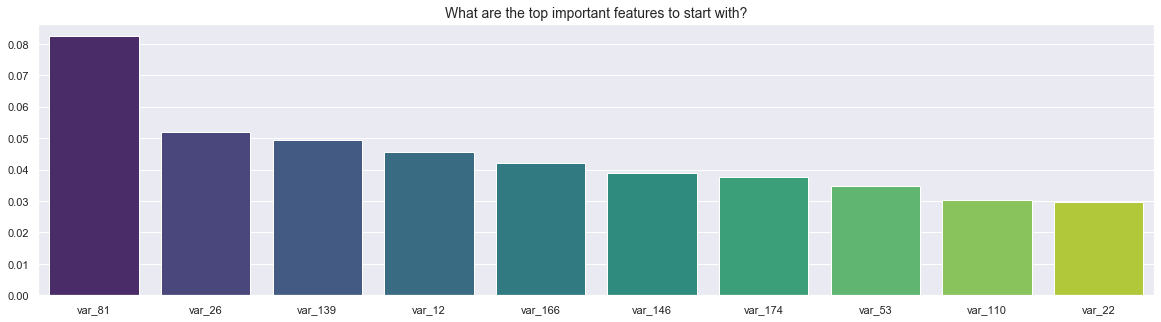

In [80]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop(TARGET_NAME, axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [87]:
RANDOM_FOREST_FEATURES = list(feature_names[idx])
RANDOM_FOREST_FEATURES

['var_81',
 'var_26',
 'var_139',
 'var_12',
 'var_166',
 'var_146',
 'var_174',
 'var_53',
 'var_110',
 'var_22']

### Pair Plot

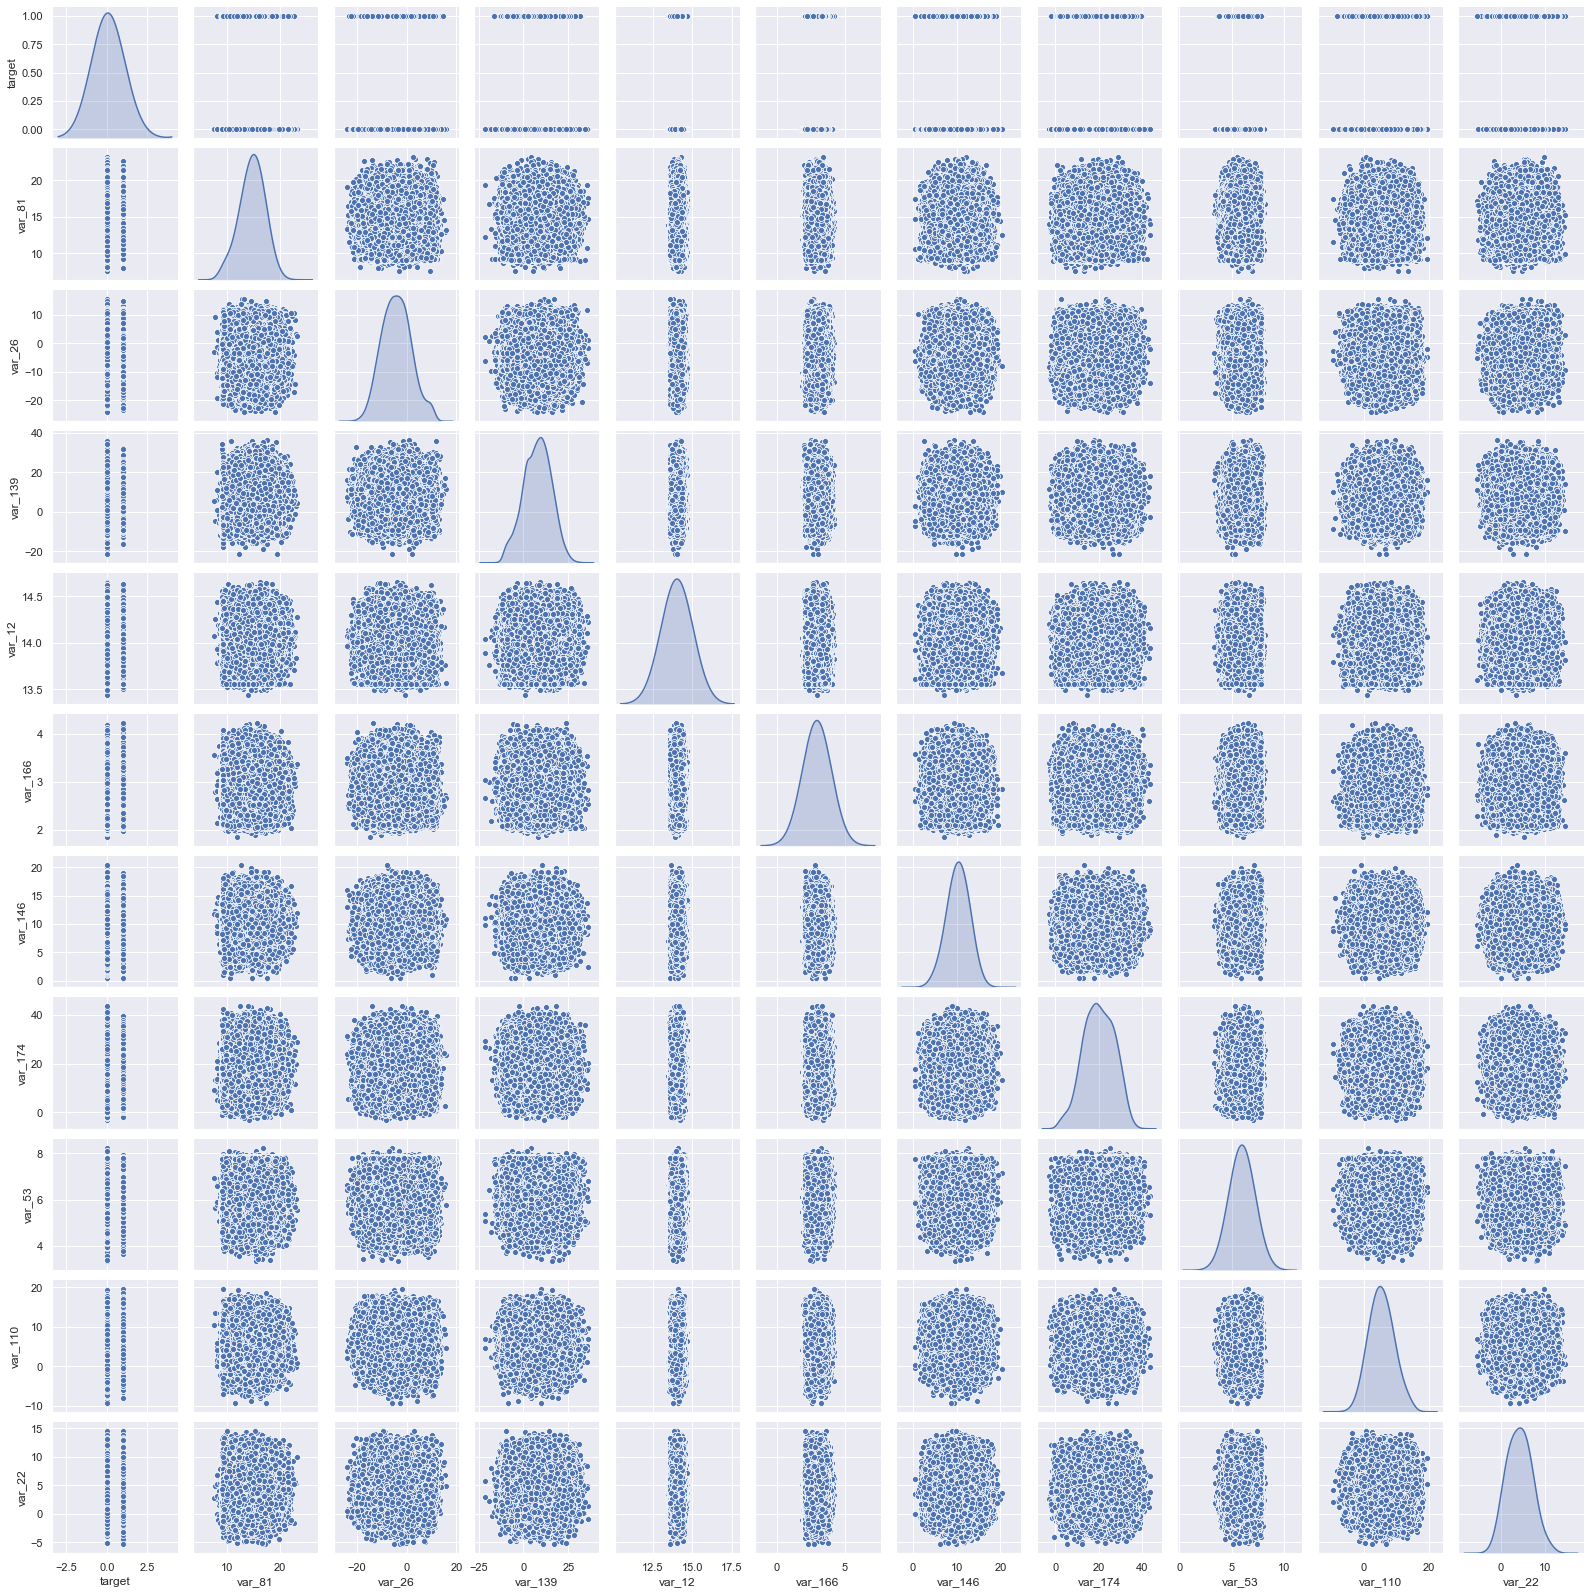

In [90]:
sns.set()
columns = [TARGET_NAME] + RANDOM_FOREST_FEATURES

sns.pairplot(train[columns], height=2, kind="scatter", diag_kind="kde", diag_kws={'bw':'1.0'})
plt.show()

### Scatter Plot

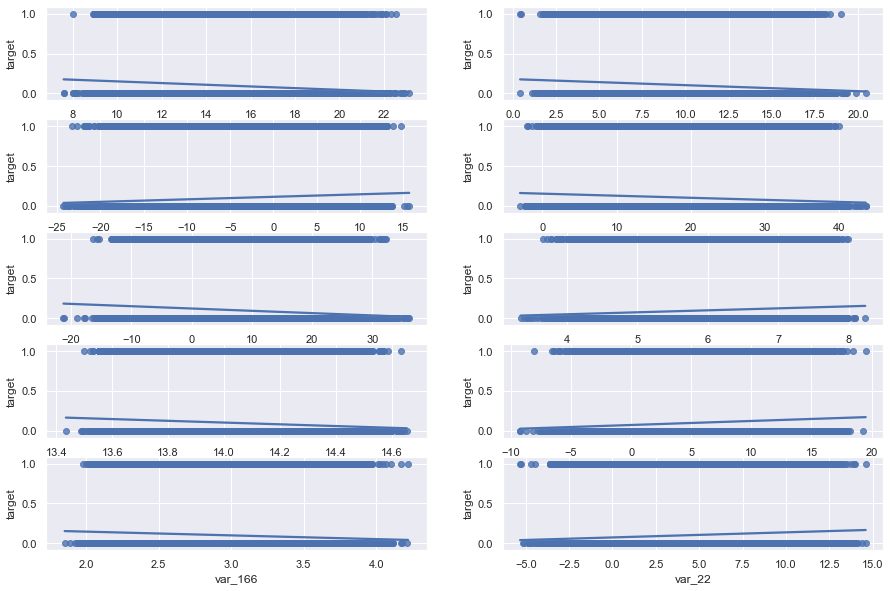

In [91]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
for num, feature in enumerate(train[RANDOM_FOREST_FEATURES]):
    sns.regplot(
        x=feature,
        y="target",
        data=train,
        ax=axes[num%5, num//5],
        scatter=True,
        fit_reg=True
    )

## BoxPlot

<function matplotlib.pyplot.show(*args, **kw)>

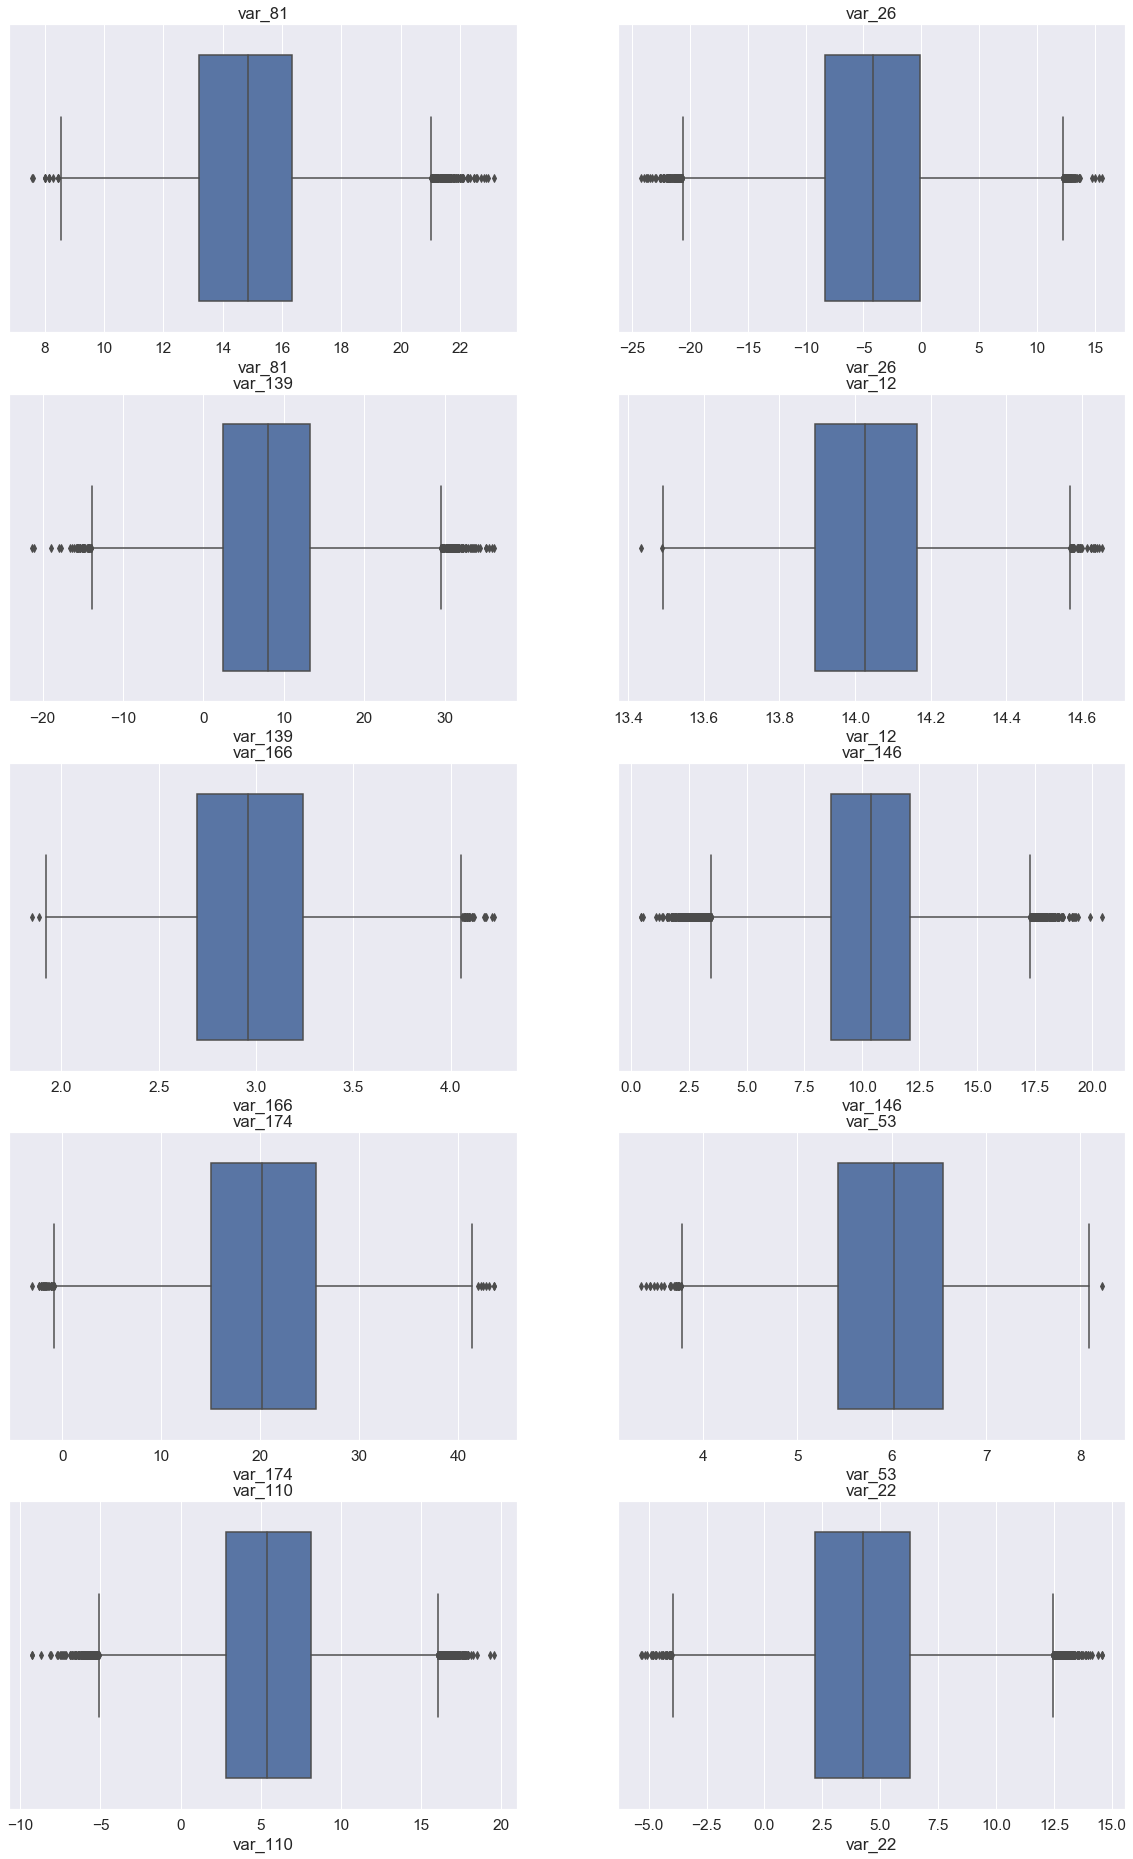

In [99]:
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))
for i, colname in enumerate(RANDOM_FOREST_FEATURES):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.boxplot(train[colname])

plt.show

## Анализ распределения на обучении и тесте

## Kolmogorov-Smirnov Test

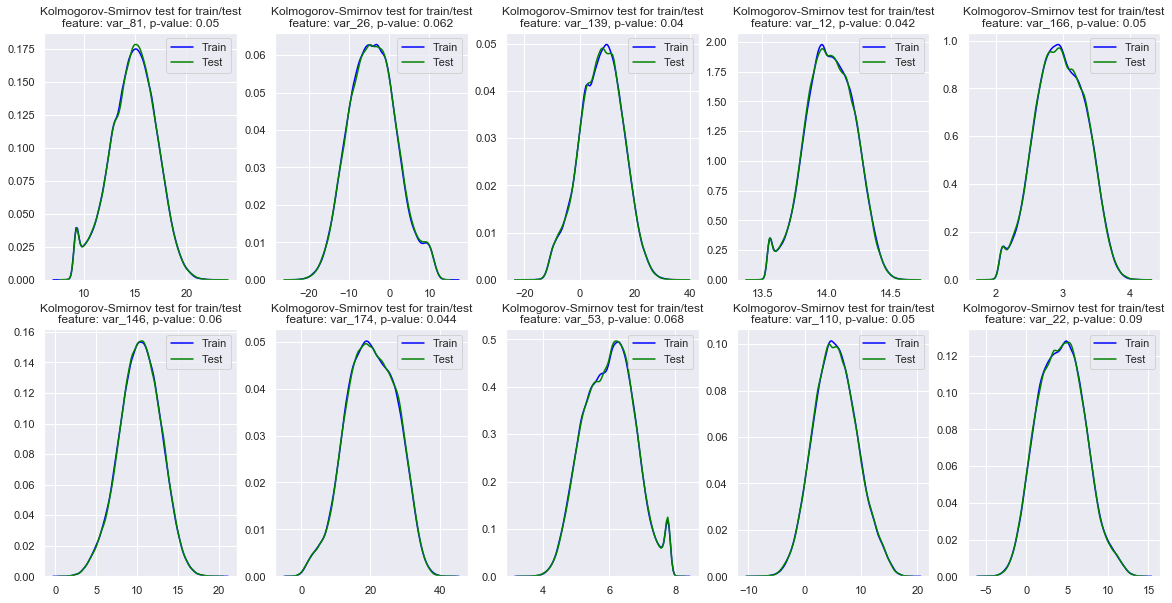

In [95]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(train[RANDOM_FOREST_FEATURES]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(test[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

## Adversarial Validation

In [96]:
X_adv = pd.concat([
    train[BASE_FEATURE_NAMES], test[BASE_FEATURE_NAMES]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [97]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5099
Wall time: 11min 51s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

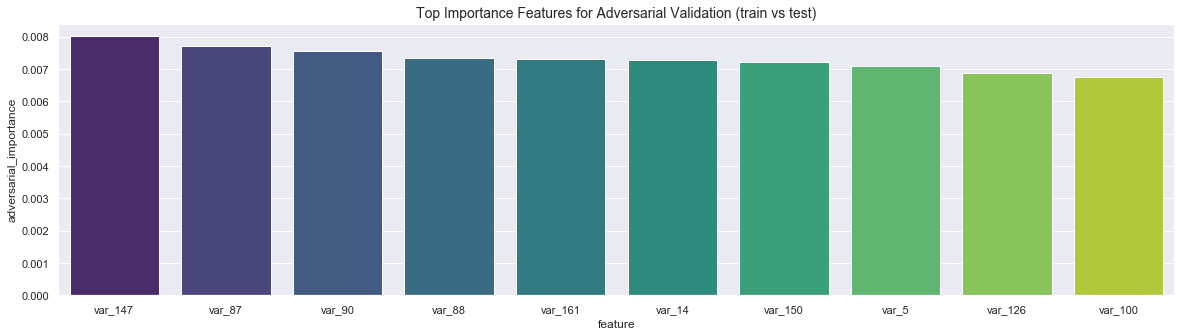

In [98]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

__Выводы__:
1. Датасет состоит из 200 числовых признаков
2. Целевая переменная-булевая. Несбалансированв (отношение 1 класса к 0 порядка 11%)
3. Features мало коррелированы с целевой переменой
4. Отсутствуют пропуски в Train и Test
5. Train и Test имеют крайне схожее распределение
6. линейная связь между признаками отсутствует
7. Нулевая гипотеза отвергается практически по тесту Колмогорова-Смирнова
8. Распределения train-test одинаковы по Adversarial Validation
9. Данные малозависимы между собой и целевой переменной, поэтому для данного датасета будет невысокие результаты. По данным похоже что заполнено случайными числами